In [1]:
%matplotlib notebook

from sdss import SDSS
import mikkel_tools.utility as mt_util

import numpy as np
from math import inf
from scipy.optimize import curve_fit
import scipy as sp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import time
import pyshtools
import pickle
import cmocean

comment = "Synthetic lithosphere newrun"
#nb_name = "nb_case_lith_synthetic_oc_thesis_final_02" # 500 degree 30
nb_name = "nb_case_lith_synthetic_oc_thesis_final_large_02" # 100 degree 60

#nb_name = "nb_case_lith_synthetic_oc_thesis_final_large_01"
shc_g = 60
shc_grid = 60

# Load core object
file_pickle = open("{}.obj".format(nb_name), 'rb')
lith = pickle.load(file_pickle)
file_pickle.close()

lith.grid_glq(nmax = shc_grid, r_at = lith.a)


In [2]:
print(lith)


______current attributes______

a:                     6371.2
r_sat:                 6721.2
r_cmb:                 3480.0
rad:                   0.017453292519943295
mu0:                   1.2566370614359173e-06
comment:               Synthetic lithosphere with different prior for continents and oceans
class_abs_path:        /home/mikotz/spherical_direct_sequential_simulation
N_SH:                  60
N_SH_secondary:        None
sim_type:              lith_ens_alt
grid_zero:             (61,), Max/Min: 1.00 / -1.00
grid_w_shtools:        (61,), Max/Min: 0.05 / 0.00
grid_shape:            (2,), Max/Min: 121.00 / 61.00
grid_w:                (7381,), Max/Min: 0.05 / 0.00
grid_radial:           (7381,), Max/Min: 6371.20 / 6371.20
grid_theta:            (7381,), Max/Min: 177.76 / 2.24
grid_phi:              (7381,), Max/Min: 357.02 / 0.00
grid_N:                7381
grid_nmax:             60
r_grid:                6371.2
grid:                  (7381, 2)
sph_d:                 (7381, 7381)

<IPython.core.display.Javascript object>


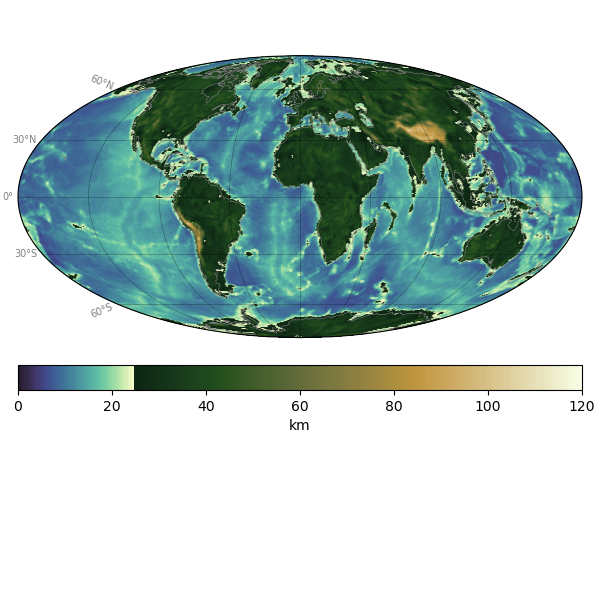

<IPython.core.display.Javascript object>


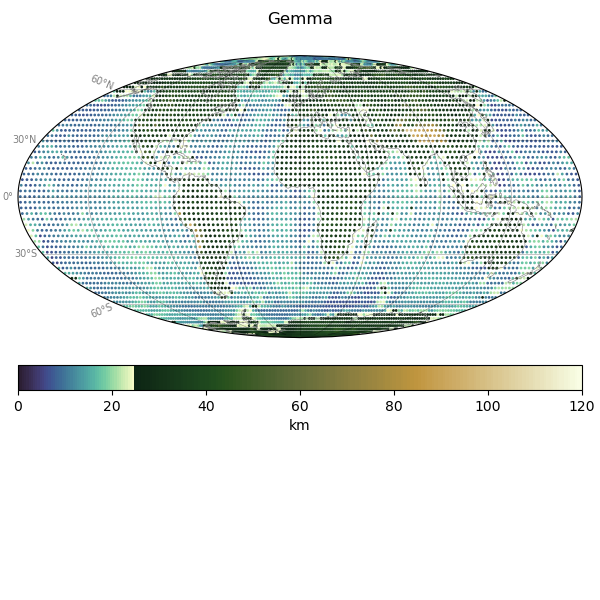

<IPython.core.display.Javascript object>


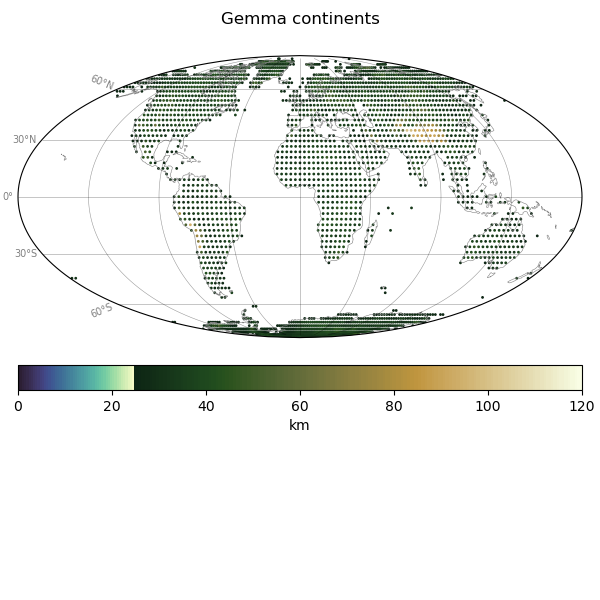

<IPython.core.display.Javascript object>


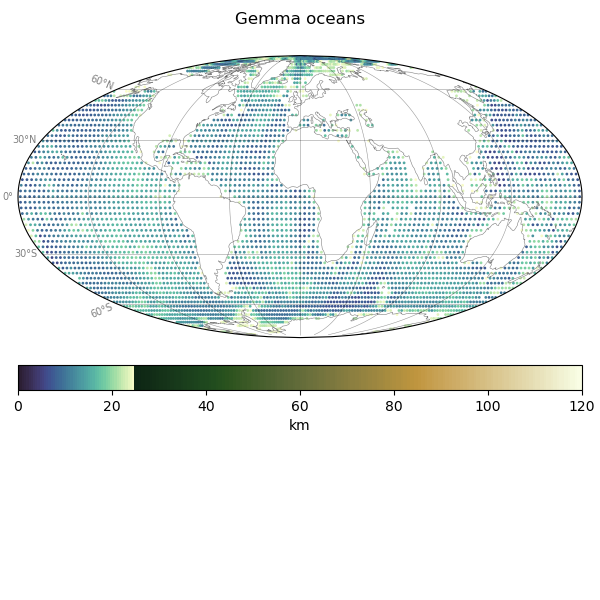

In [3]:
crust_gemma = np.load("mikkel_tools/models_grid/crust_gemma_p05.npy").reshape(360,720)
crust_gemma = np.hstack((crust_gemma[:,360:],crust_gemma[:,:360])).reshape(-1,)
crust_gemma_err = np.load("mikkel_tools/models_grid/crust_gemma_err_p05.npy").reshape(360,720)
crust_gemma_err = np.hstack((crust_gemma_err[:,360:],crust_gemma_err[:,:360])).reshape(-1,)

gemma_phi, gemma_theta = np.meshgrid(np.arange(0,360,0.5), np.arange(0,180,0.5))
gemma_phi = gemma_phi.reshape(-1,)
gemma_theta = gemma_theta.reshape(-1,)

crust_gemma_itp = mt_util.interpolate_grid(gemma_theta, lith.grid_theta, gemma_phi, lith.grid_phi, crust_gemma, 
                                        method_int = "nearest")

mt_util.plot_global(lat = 90-gemma_theta, lon = gemma_phi, data=crust_gemma, limits_data = [0,120],
                cbar_h = 0.075, unit_transform_n_to_m = False, cbar_even = False,
                cbar_text = "km", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='', point_size=1,
                savefig = False, save_dpi = 100, 
                save_string ="gemma_split_synth_lith", save_path = "images_thesis/",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4, midnorm = 25, 
                cmap=cmocean.cm.topo)

mt_util.plot_global(lat = 90-lith.grid_theta, lon = lith.grid_phi, data=crust_gemma_itp, limits_data = [0,120],
                cbar_h = 0.075, unit_transform_n_to_m = False, cbar_even = False,
                cbar_text = "km", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Gemma', point_size=1,
                savefig = False, save_dpi = 100, save_string ="case_synthetic_lith",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4, midnorm = 25, 
                cmap=cmocean.cm.topo)

idx_c = crust_gemma_itp>25
idx_o = ~idx_c.copy()

mt_util.plot_global(lat = 90-lith.grid_theta[idx_c], lon = lith.grid_phi[idx_c], data=crust_gemma_itp[idx_c], 
                    limits_data = [0,120],
                cbar_h = 0.075, unit_transform_n_to_m = False, cbar_even = False,
                cbar_text = "km", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Gemma continents', point_size=1,
                savefig = False, save_dpi = 100, save_string ="case_synthetic_lith",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4, midnorm = 25, 
                cmap=cmocean.cm.topo)

mt_util.plot_global(lat = 90-lith.grid_theta[idx_o], lon = lith.grid_phi[idx_o], data=crust_gemma_itp[idx_o], 
                    limits_data = [0,120],
                cbar_h = 0.075, unit_transform_n_to_m = False, cbar_even = False,
                cbar_text = "km", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Gemma oceans', point_size=1,
                savefig = False, save_dpi = 100, save_string ="case_synthetic_lith",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4, midnorm = 25, 
                cmap=cmocean.cm.topo)

idx_c_cov = idx_c.reshape(-1,1)@idx_c.reshape(1,-1)
idx_o_cov = idx_o.reshape(-1,1)@idx_o.reshape(1,-1)

In [4]:
# Continents
lith.grid_glq(nmax = shc_grid, r_at = lith.a)

lith.grid_radial = lith.grid_radial[idx_c]
lith.grid_theta = lith.grid_theta[idx_c]
lith.grid_phi = lith.grid_phi[idx_c]
lith.grid_N = len(lith.grid_phi)
lith.grid_w = lith.grid_w[idx_c]

grid_in = np.array([lith.grid_phi, 90-lith.grid_theta]).T
lith.make_grid(lith.a, grid_in, calc_sph_d = True)
lith.generate_map()

lith.semivar(model_lags = 10, model = "exponential", max_dist = 20000, lag_length = 500, zero_nugget = False)

sv_c = lith.sv_lut.copy()
tv_c = np.max(sv_c)

____semi-variogram setup___

Number of data used: 8065584
Max data distance: 19992.516 km
Lag length chosen: 500.0 km
Number of lags: 39
Number of modelling lags: 10

Semi-variogram model determined, starting LUT computation



In [5]:
# CONTINENTS
lags_c = lith.lags.copy()
pics_c = lith.pics.copy()
lags_sv_curve_c = lith.lags_sv_curve.copy()
sv_curve_c = lith.sv_curve.copy()

In [26]:
# Oceans
lith.grid_glq(nmax = shc_grid, r_at = lith.a)

lith.grid_radial = lith.grid_radial[idx_o]
lith.grid_theta = lith.grid_theta[idx_o]
lith.grid_phi = lith.grid_phi[idx_o]
lith.grid_N = len(lith.grid_phi)
lith.grid_w = lith.grid_w[idx_o]

grid_in = np.array([lith.grid_phi, 90-lith.grid_theta]).T
lith.make_grid(lith.a, grid_in, calc_sph_d = True)
lith.generate_map()

#lith.semivar(model_lags = "all", model = "exponential", max_dist = 20000, lag_length = 500, zero_nugget = False)
lith.semivar(model_lags = "all", model = "exponential", max_dist = 20000, lag_length = 250, zero_nugget = False)

sv_o = lith.sv_lut.copy()
tv_o = np.max(sv_o)

____semi-variogram setup___

Number of data used: 20620653
Max data distance: 19992.516 km
Lag length chosen: 250.0 km
Number of lags: 79
Number of modelling lags: all

Semi-variogram model determined, starting LUT computation



In [27]:
# Oceans
lags_o = lith.lags.copy()
pics_o = lith.pics.copy()
lags_sv_curve_o = lith.lags_sv_curve.copy()
sv_curve_o = lith.sv_curve.copy()

<IPython.core.display.Javascript object>


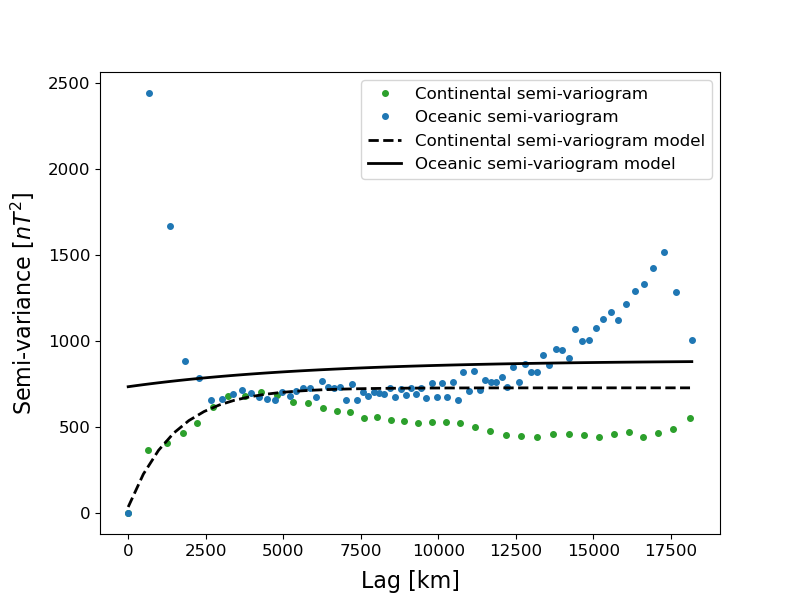

In [29]:

#%% PLOT SEMI-VARIOGRAM
plt.figure(figsize=(8,6)) 
plt.plot(lags_c,pics_c,'o', markersize=4,color = 'C2',label='Continental semi-variogram')
plt.plot(lags_o,pics_o,'o', markersize=4,color = 'C0',label='Oceanic semi-variogram')
plt.plot(lags_sv_curve_c,sv_curve_c, '--', color='k',linewidth = 2,label='Continental semi-variogram model')
plt.plot(lags_sv_curve_o,sv_curve_o, '-', color='k',linewidth = 2,label='Oceanic semi-variogram model')
plt.ylabel('Semi-variance $[%s^2]$' % "nT",fontsize=16,labelpad=8)
plt.xlabel('Lag [km]',fontsize=16,labelpad=8)
plt.legend(loc='best',fontsize=12)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
#plt.savefig('images_thesis/lith_synth_sv_models_final_02.png', bbox_inches='tight', dpi = 100) 
plt.show()

In [9]:
# Combine
lith.grid_glq(nmax = shc_grid, r_at = lith.a)

grid_in = np.array([lith.grid_phi, 90-lith.grid_theta]).T
lith.make_grid(lith.a, grid_in, calc_sph_d = True)
lith.generate_map()

C_mm_in = np.zeros((lith.grid_N*lith.grid_N,))

C_mm_in[idx_c_cov.reshape(-1,)] = tv_c - sv_c.reshape(-1,)
C_mm_in[idx_o_cov.reshape(-1,)] = tv_o - sv_o.reshape(-1,)

C_mm_in = C_mm_in.reshape(lith.grid_N,lith.grid_N)

In [10]:
# Synth sat
C_e_const = 0.1

s_sat = SDSS(comment, N_SH = shc_g, sim_type = "lith_ens_alt_synth_truth", sat_height = 350, N_SH_secondary = None)

s_sat.load_swarm("A")

grid_in = np.array([s_sat.grid_phi, 90-s_sat.grid_theta]).T
s_sat.make_grid(s_sat.grid_radial, grid_in, calc_sph_d = False)

s_sat.generate_map(grid_type = "swarm")

s_sat.data += np.random.normal(scale = C_e_const, size = s_sat.data.shape)

In [11]:
# Source truth
s_source = SDSS(comment, N_SH = shc_g, sim_type = "lith_ens_alt_synth_truth", sat_height = 350, N_SH_secondary = None)

s_source.grid_glq(nmax = shc_grid, r_at = s_source.a)

grid_in = np.array([s_source.grid_phi, 90-s_source.grid_theta]).T
s_source.make_grid(s_source.a, grid_in, calc_sph_d = False)

s_source.generate_map()

In [12]:
lith.integrating_kernel(s_sat, C_e_const = C_e_const, C_mm_supply = C_mm_in)

In [13]:
lith.grid_glq(nmax = shc_g, r_at = lith.a)

g_mean, _ = mt_util.sh_expand_glq(np.mean(lith.m_DSS,axis=1), lith.grid_nmax, 
                                  lith.grid_w_shtools, lith.grid_zero, shc_g, geomag_r_at = lith.a)        
lith.g_spec_mean = np.array(g_mean).T.reshape(-1,)

lith.ensemble_B(lith.g_spec, nmax = shc_g, r_at = lith.a, grid_type = "glq")
zs_DSS = lith.B_ensemble[:,0].copy()
lith.m_DSS = zs_DSS.copy()

lith.m_DSS_pred = lith.G@lith.m_DSS
lith.m_DSS_res = s_sat.data.reshape(-1,1) - lith.m_DSS_pred

m_DSS_pred_mean = lith.G@np.mean(lith.m_DSS, axis=1).reshape(-1,1)
m_DSS_res_mean = s_sat.data.reshape(-1,1) - m_DSS_pred_mean

<IPython.core.display.Javascript object>


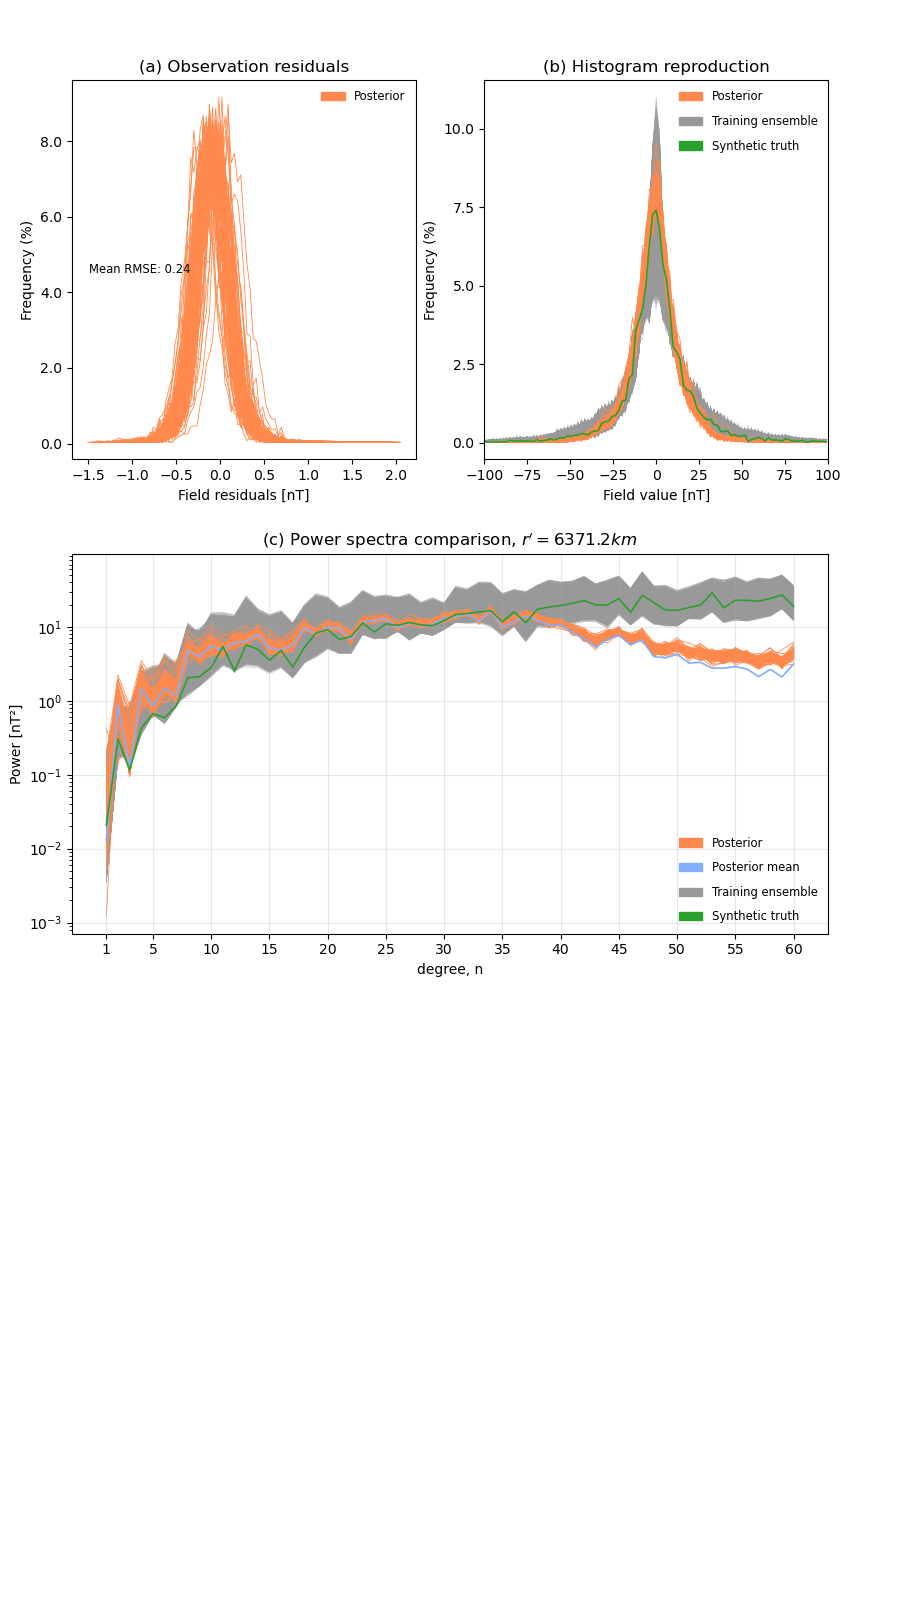

In [15]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

#truth_obj = s_source

lith.grid_glq(nmax = shc_grid, r_at = lith.a)
mt_util.plot_sdssim_reproduce(lith, lith.m_DSS_res, m_equiv_lsq = None, truth_obj = s_source,
                              lags_use = 1000, spec_r_at = lith.a, spec_show_differences = False,
                              spec_ti_ens = True, lwidth = 0.6, lwidth_div = 3, lwidth_mult = 2,
                              label_fontsize = "small", hist_ti_ens_limit = [-100,100],
                              res_use = True, sv_use = False, unit_field = "[nT]",
                              unit_transform_n_to_m = False, patch_legend = True, ens_prior = True,
                              model_dict = {}, figsize=(9,16), hist_ti_ens = "all", hist_density = False,
                              hist_bins = 101, res_bins = 101, hist_pos_mean = False,
                              left=0.08, bottom=0.12, right=0.92, top=0.95, wspace = 0.2, hspace=0.25,
                              savefig = False, save_string = "case_lith_synthetic_oc_thesis_final_large_02", 
                              save_dpi = 100, save_path = "images_thesis/")

In [16]:
lith.grid_glq(nmax = 256, r_at = lith.a)

set_nmax = shc_grid

lith.ensemble_B(lith.g_spec, nmax = set_nmax, r_at = lith.a, grid_type = "glq")
zs_eqa = lith.B_ensemble[:,0,:].copy()

lith.ensemble_B(lith.g_spec_mean, nmax = set_nmax, r_at = lith.a, grid_type = "glq")
zs_mean_eqa = lith.B_ensemble[:,0].copy()

lith.ensemble_B(s_sat.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = lith.a, grid_type = "glq")
prior_eqa = lith.B_ensemble[:,0].copy()

#core.ensemble_B(core.g_lsq_equiv, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
#lsq_eqa = core.B_ensemble[:,0].copy()

<IPython.core.display.Javascript object>


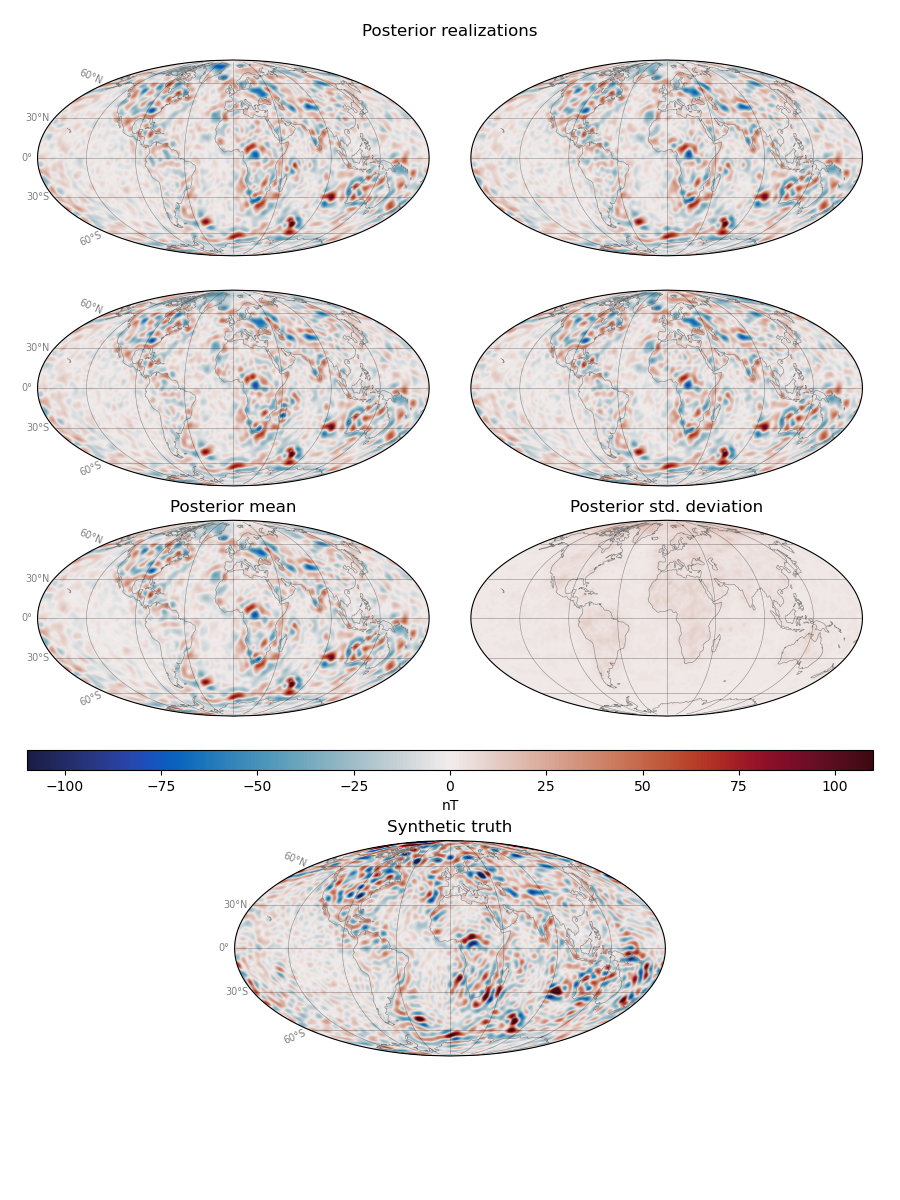

In [18]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)
# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

mt_util.plot_ensemble_map_tiles(lith.grid_phi, 90-lith.grid_theta, zs_eqa, 
                        field_compare = prior_eqa, field_lsq = None, field_mean = zs_mean_eqa,
                        tile_size_row = 3, tile_size_column = 2, 
                        figsize=(9,12), limit_for_SF = 10**6, point_size = 0.1, cbar_mm_factor = 0.25,
                        coast_width = 0.4, coast_color = "grey", unit_transform_n_to_m = False,
                        cbar_h = 0.1, cbar_text = "nT", cbar_text_color = "black",
                        left=0.03, bottom=0.12, right=0.97, top=0.95, wspace = 0.05, hspace=0.25, 
                        savefig = False, save_string = "case_lith_synthetic_oc_thesis_final_large_02", 
                        projection = ccrs.Mollweide(), use_gridlines = True, 
                        gridlines_width = 0.4, gridlines_alpha = 0.4, save_dpi = 100, save_path = "images_thesis/", 
                        cmap=cmocean.cm.balance)


<IPython.core.display.Javascript object>


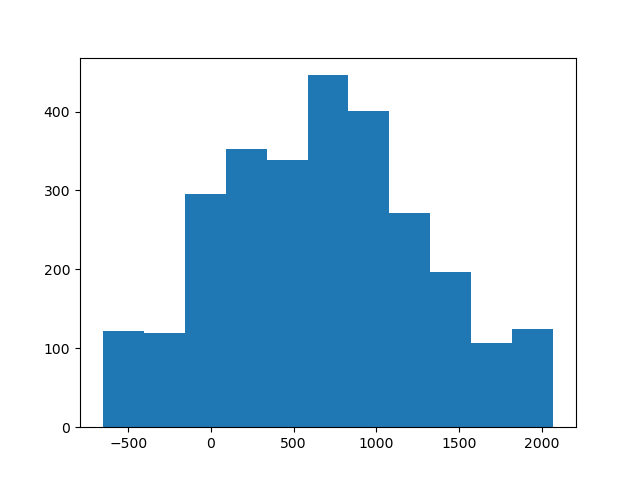

In [4]:
# MODE FROM M
core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)
m_DSS_hist = []
m_DSS_hist_y = []
for i in np.arange(0,core.m_DSS.shape[0]):
    y,binEdges=np.histogram(core.m_DSS[i,:],bins=21)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    m_DSS_hist.append(bincenters)
    m_DSS_hist_y.append(y)
    
m_DSS_hist = np.array(m_DSS_hist).T
m_DSS_hist_y = np.array(m_DSS_hist_y).T

idx_max_y = np.argmax(m_DSS_hist_y,axis=0)

m_DSS_mode = []
for i in np.arange(0,core.m_DSS.shape[0]):
    m_DSS_mode.append(m_DSS_hist[idx_max_y[i],i])
    
m_DSS_mode = np.array(m_DSS_mode)[:,None]

set_nmax = shc_grid
g_DSS_mode, _ = mt_util.sh_expand_glq(m_DSS_mode, core.grid_nmax, core.grid_w_shtools, core.grid_zero, set_nmax, geomag_r_at = core.r_cmb)        
g_DSS_mode = np.array(g_DSS_mode).T

core.g_spec_mode = g_DSS_mode

m_DSS_mode_pred = core.G@m_DSS_mode
m_DSS_mode_res = s_sat.data.reshape(-1,1) - m_DSS_mode_pred

plt.figure()
plt.hist(m_DSS_mode_res,bins=11)
plt.show()